In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.special import comb
import math

In [2]:
def discretize_bezier(N, control_points):
    # Compute the Bezier curve for a given set of control points.
    control_points = np.array(control_points)
    n = len(control_points) - 1

    def bernstein_poly(i, n, t):
        return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

    t = np.linspace(0, 1, N)
    curve = np.zeros((N, control_points.shape[1]))

    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), control_points[i])

    return curve

In [3]:
def discretize_line(point1, point2, N):
    # Discretize a line given 2 points and N number of points.
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.linspace(point1, point2, N)

In [4]:
# Main Code

def main(path : str):
    # Number of points discretized
    t = 1000
    discretized_points = []


    with(open(path, 'r')) as f:
        data = json.load(f)

    N = data['N']
    curves = data['curves']
    types = [curves[i]['type'] for i in range(len(curves))]

    for i in range(N):
        if types[i] == 'bezier':
            # Extracting control points
            control_points = []
            point1 = [data['x_ref'][i], data['y_ref'][i]]
            point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]

            control_points.append(point1)
            xref = curves[i]['x_ctr']
            yref = curves[i]['y_ctr']
            n = len(xref)
            for j in range(n):
                control_points.append([xref[j], yref[j]])
            control_points.append(point2)
            
            # Discretizing the Bezier curve
            points = discretize_bezier(t, control_points)
            discretized_points.append(points.tolist())

        elif types[i] == 'droite':
            # Discretizing the line
            point1 = [data['x_ref'][i], data['y_ref'][i]]
            point2 = [data['x_ref'][i+1], data['y_ref'][i+1]]
            points = discretize_line(point1, point2, t)
            discretized_points.append(points.tolist())

    return discretized_points

discretized_points = main('tests/testC.json')

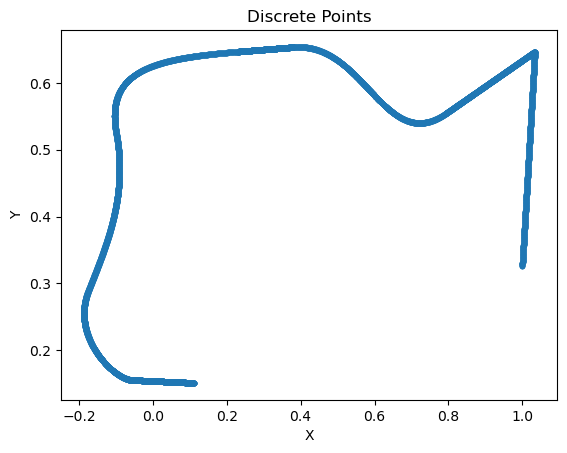

[[0.11192687553854051, 0.15108694698552613], [0.11175827987962461, 0.15109125708790988], [0.11158968422070872, 0.1510955671902936], [0.11142108856179282, 0.15109987729267735], [0.11125249290287692, 0.15110418739506107], [0.11108389724396103, 0.15110849749744482], [0.11091530158504513, 0.15111280759982854], [0.11074670592612923, 0.15111711770221228], [0.11057811026721334, 0.15112142780459603], [0.11040951460829744, 0.15112573790697975], [0.11024091894938154, 0.1511300480093635], [0.11007232329046565, 0.15113435811174722], [0.10990372763154975, 0.15113866821413097], [0.10973513197263386, 0.1511429783165147], [0.10956653631371796, 0.15114728841889843], [0.10939794065480206, 0.15115159852128215], [0.10922934499588617, 0.1511559086236659], [0.10906074933697027, 0.15116021872604965], [0.10889215367805437, 0.15116452882843337], [0.10872355801913848, 0.15116883893081712], [0.10855496236022258, 0.15117314903320084], [0.10838636670130668, 0.15117745913558459], [0.10821777104239079, 0.15118176923

In [5]:
def flatten_points_as_lists(nested_list):
    # Flattens a deeply nested list of lists into a single list of points, 
    # keeping points as lists.
    flat_points = []
    for item in nested_list:
        if isinstance(item, list):
            # If the item is a list, recursively process it
            if len(item) == 2 and all(isinstance(coord, (int, float)) for coord in item):
                # Append directly if it's a point-like structure
                flat_points.append(item)
            else:
                # Otherwise, recursively flatten the sublist
                flat_points.extend(flatten_points_as_lists(item))
    return flat_points



# Plotting the discretized points
flattened_points = flatten_points_as_lists(discretized_points)
plt.plot(np.array(flattened_points)[:, 0], np.array(flattened_points)[:, 1], '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Discrete Points')
plt.show()


print(flattened_points)

$$\Delta s_i = s_{i+1} - s_{i} = \delta$$

In [6]:
def interp_s(x, y, s_old, s_target):
    # Interpolate x and y at s_target based on s_old
    i = 0
    while i < len(s_old) - 1 and not (s_old[i] <= s_target <= s_old[i+1]):
        i += 1
    if i == len(s_old) - 1:
        return x[-1], y[-1]
    seg_length = s_old[i+1] - s_old[i]
    if seg_length < 1e-14:
        return x[i], y[i]
    t = (s_target - s_old[i]) / seg_length
    xx = x[i] + t * (x[i+1] - x[i])
    yy = y[i] + t * (y[i+1] - y[i])
    return xx, yy

In [7]:
def curvature(points):
    ds_list = []
    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        ds_list.append(math.sqrt(dx*dx + dy*dy))

    s = [0.0]
    for dist in ds_list:
        s.append(s[-1] + dist)

    L = s[-1]

    return s, L

s, L = curvature(flattened_points)

L

2.2059885111215007

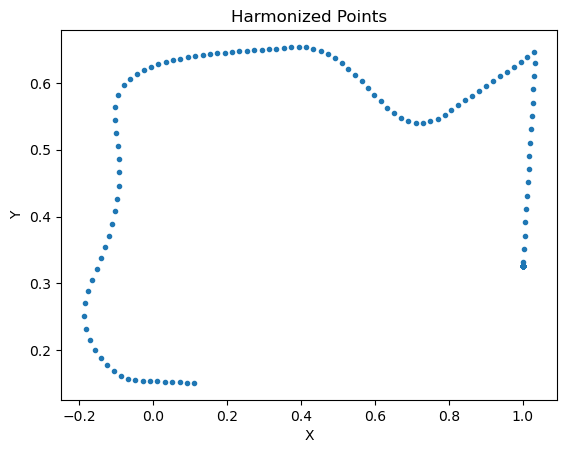

In [8]:
def harmonize_points(points, delta, epsilon=0.0005, max_points=1000):
    # Uniformly sample points along the curve
    s = curvature(points)[0]
    N = max_points


    s_new = [0 for i in range(N)]
    for j in range(1,N):
        s_new[j] = s_new[j-1] + delta

    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    npoints = []

    for val in s_new:
        xx, yy = interp_s(x, y, s, val)
        npoints.append([xx, yy])

    return npoints

# Plotting the harmonized points
harmonized_points = np.array(harmonize_points(flattened_points, 0.02))

plt.plot(harmonized_points[:, 0], harmonized_points[:, 1], '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Harmonized Points')
plt.show()


$$\Delta s_i = s_{i+1} - s_{i} = \alpha*\beta^{n-1-i}$$



In [9]:
def findN(L, alpha, beta):
    # Finding the number of points N for the geometrical law
    a = 1 - L/alpha * (1 - beta)
    if a <= 0 or beta == 1 :
        raise ValueError("Invalid values for alpha, beta and L")
    return round(1 + math.log(a) / math.log(beta))

findN(L, 0.01, 1.2)

22

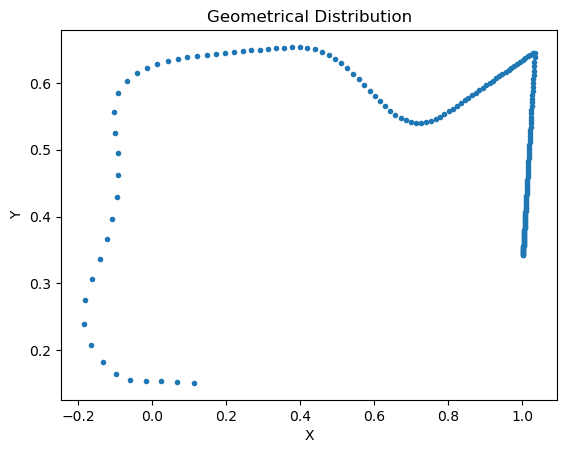

In [10]:
# Geometrical law
def geo_points(points, alpha, beta):
    s = curvature(points)[0]
    L = curvature(points)[1]
    N = findN(L, alpha, beta)

    s_new = [0 for i in range(N)]
    for j in range(1,N):
        s_new[j] = s_new[j-1] + alpha*(beta**(N-j-1))

    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    npoints = []

    for val in s_new:
        xx, yy = interp_s(x, y, s, val)
        npoints.append([xx, yy])

    return npoints

# Plotting the geometrically spaced points
npoints = np.array(geo_points(flattened_points, 0.001, 1.02))
plt.plot(npoints[:, 0], npoints[:, 1], '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Geometrical Distribution')
plt.show()

    

$$\Delta s_i = s_{i+1} - s_{i} = \frac{\delta}{|k(s_i)^\alpha|}$$

In [11]:
def remove_duplicates(x, y, tol=0.01):
    # Very sensible to the tolerance
    new_x = [x[0]]
    new_y = [y[0]]
    for i in range(1, len(x)):
        dx = x[i] - new_x[-1]
        dy = y[i] - new_y[-1]
        dist = math.sqrt(dx*dx + dy*dy)
        if dist > tol:
            new_x.append(x[i])
            new_y.append(y[i])
    return new_x, new_y


# To be optimised
new_x, new_y = remove_duplicates(np.array(flattened_points)[:, 0], np.array(flattened_points)[:, 1])
flattened_points = [[new_x[i],new_y[i]] for i in range(len(new_x))]

In [12]:
def k(x, y, i):
    # Calculating the curvature at a point
    if i == 0 :
        return k(x, y, 1)
    elif i == len(x) - 1:
        return k(x, y, len(x) - 2)
    else :
        area = 1/2 * (abs((x[i] - x[i-1])*(y[i+1] - y[i]) - (x[i+1] - x[i-1])*(y[i] - y[i-1])))
        sideA = math.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2)
        sideB = math.sqrt((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2)
        sideC = math.sqrt((x[i+1] - x[i-1])**2 + (y[i+1] - y[i-1])**2)
        return max(4 * area / (sideA * sideB * sideC), 1e-10)


In [13]:
def findD(L, x, y, alpha):
    # Finding delta
    res = 0
    for i in range(len(x)-1):
        res += 1 / (abs(k(x,y,i))**alpha)
    return L / res


findD(L, np.array(flattened_points)[:, 0], np.array(flattened_points)[:, 1], 0.45)

np.float64(0.030450436124785544)

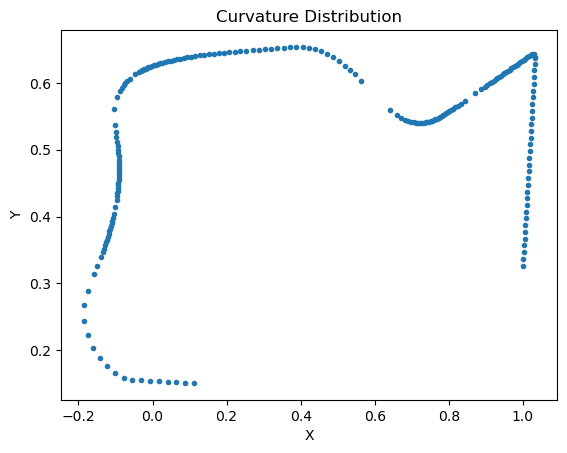

In [14]:
def curvature_points(points, alpha):
    # Curvature law
    s = curvature(points)[0]
    L = curvature(points)[1]
    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    delta = findD(L, x, y, alpha)
    N = len(x)

    s_new = [0 for _ in range(N)]
    for j in range(1,N):
        #print(delta/(abs(k(x,y,j-1))**alpha))
        s_new[j] = s_new[j-1] + delta/(abs(k(x,y,j-1))**alpha)

    x, y = np.array(points)[:, 0], np.array(points)[:, 1]
    npoints = []

    for val in s_new:
        xx, yy = interp_s(x, y, s, val)
        npoints.append([xx, yy])

    return npoints


# Plotting the curvature spaced points
cpoints = np.array(curvature_points(flattened_points, 0.6))
plt.plot(cpoints[:, 0], cpoints[:, 1], '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curvature Distribution')
plt.show()